# Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Import training and test data

In [2]:
train_data = pd.read_csv('movement_data/fingerprinting_data/train.csv')
test_data = pd.read_csv('movement_data/fingerprinting_data/test.csv')

# Prepare data for model training and validation

In [3]:
def normalise_impute_input(input_features):
    """
    This function normalises the RSSI values into values that fall between 0 and 1.
    Any missing values will be given the maximum value of 1.
    """
    input_features = np.abs(input_features)  # ensure that all rssi values are positive
    num_features = len(input_features[0,:])
    max_value = np.zeros(num_features)
    min_value = np.zeros(num_features)

    for i in range(num_features):
        min_value[i] = np.nanmin(input_features[:,i])
        max_value[i] = np.nanmax(input_features[:,i])
        input_features[:,i] = (input_features[:,i] - min_value[i]) / (max_value[i] - min_value[i] + 1e-6)
    
    input_features[np.isnan(input_features)] = 1.0
        
    return input_features

In [4]:
def prepare_data(data):
    """
    This function splits the data into input features and labels and returns them as outputs.
    """
    data = data.sample(frac=1).reset_index(drop=True)  # shuffle the data
    
    X = data.loc[:,'RSSI_AssemblyEntrance':'RSSI_Printer'].values
    X = normalise_impute_input(X)
    Y = data['Model1']
    
    return X, Y

In [5]:
Xtrain, Ytrain = prepare_data(train_data)
Xtest, Ytest = prepare_data(test_data)

# Model training and hyperparameter tuning via random cross validation

In [6]:
def hyperparameter_tuning(Xtrain, Ytrain):
    """
    This function performs hyperparmeter tuning using a 5-fold cross validation approach, based
    on the training dataset and returns the optimised model.
    """
    param_grid = {'n_estimators': np.arange(50, 201, 10),
                  'min_samples_leaf': np.arange(1,6),
                  'min_samples_split': np.arange(2,6),
                  'max_depth': np.arange(2,6)}

    random_cv = RandomizedSearchCV(GradientBoostingClassifier(), param_grid, n_iter=500, 
                                   cv=5, verbose=2, scoring='f1_macro', n_jobs=-1)
    random_cv.fit(Xtrain, Ytrain)
    
    print('Best Model Parameters')
    print(random_cv.best_params_)
    
    return random_cv.best_estimator_

In [7]:
best_model = hyperparameter_tuning(Xtrain, Ytrain)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 66.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 124.5min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 197.8min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 266.1min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 339.9min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 383.4min finished


Best Model Parameters
{'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 4}


best model parameters: n_estimators: 130, min_samples_split: 2, min_samples_leaf: 4, max_depth: 3

# Calculate test performance

In [8]:
def plot_model_performance(true_label, prediction):
    """
    This function compares the predicted location with the true location information
    and presents the model performance using a classification report and a confusion
    matrix.
    """
    # Classification report
    print(classification_report(true_label, prediction))
    
    # Confusion matrix in the form of a heat map
    cm = confusion_matrix(true_label, prediction)
    cm = pd.DataFrame(cm)
    sns.heatmap(cm, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

                                precision    recall  f1-score   support

                 AssemblySpace       1.00      0.71      0.83       296
              LaserCuttingRoom       0.92      0.86      0.89       960
                   MeetingRoom       0.49      0.94      0.64       146
                  OfficeArea_1       0.78      0.90      0.84       789
                  OfficeArea_2       0.95      0.86      0.91      1338
                           Out       1.00      1.00      1.00       154
    Pantry_FridgeCoffeeMachine       0.78      0.34      0.47       627
Pantry_MicrowaveWaterDispenser       0.18      0.83      0.29        53
                  Pantry_Other       0.16      0.31      0.21       129
                 PrecisionRoom       0.57      1.00      0.73       149
                       Printer       0.79      0.76      0.77       151
               PrototypingRoom       0.86      0.67      0.75       272

                      accuracy                           0.78 

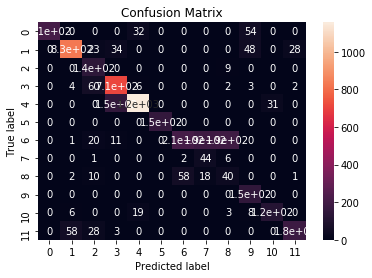

In [9]:
prediction = best_model.predict(Xtest)
plot_model_performance(Ytest, prediction)

# Reduce input dimensionality using feature importance scores

In [10]:
def plot_feature_importance(model, input_columns):
    """
    This function calculates the feature importance score of each input feature and plots
    them on a pareto chart in descending order.
    """
    cutoff = 1

    feature_importance = pd.DataFrame(model.feature_importances_)
    x_axis = input_columns
    feature_importance.index = x_axis
    feature_importance.columns = ['Feature Importance Score']
    feature_importance.sort_values(by='Feature Importance Score',axis=0,ascending=False, inplace=True)

    pareto_score = []
    total_score = sum(feature_importance['Feature Importance Score'])
    cumulative_score = 0
    for index in feature_importance.index:
        cumulative_score += feature_importance.loc[index,'Feature Importance Score']
        if cumulative_score <= cutoff:
            pareto_score.append(cumulative_score/total_score * 100)
        else:
            break

    feature_importance_cutoff_index = feature_importance.index[:len(pareto_score)]
    print(feature_importance_cutoff_index)
    feature_importance_cutoff = feature_importance.loc[feature_importance_cutoff_index[0]:feature_importance_cutoff_index[len(pareto_score)-1],:]

    fig, ax = plt.subplots()
    fig = plt.xticks(rotation=90)
    fig = sns.barplot(x=feature_importance_cutoff.index,y=feature_importance_cutoff['Feature Importance Score'], ax=ax)
    ax2 = ax.twinx()
    ax2.set_ylabel("Cumulative % of Total Importance Score")
    fig = sns.lineplot(x=np.arange(len(feature_importance_cutoff)), y=pareto_score, ax=ax2, color='black')

Index(['RSSI_Workshop', 'RSSI_LabManagerOffice', 'RSSI_LaserCuttingEntrance',
       'RSSI_Ada', 'RSSI_Fridge', 'RSSI_PrecisionEntrance',
       'RSSI_ResearcherEntrance', 'RSSI_WaterDispenser', 'RSSI_CoffeeMachine',
       'RSSI_Stratasys', 'RSSI_Printer', 'RSSI_PrecisionRoom',
       'RSSI_3DPrinter', 'RSSI_Microwave', 'RSSI_PrototypingRoom',
       'RSSI_LaserCutter', 'RSSI_AssemblySpace', 'RSSI_PrototypingEntrance',
       'RSSI_AssemblyEntrance', 'RSSI_MeetingRoom', 'RSSI_Carlye'],
      dtype='object')


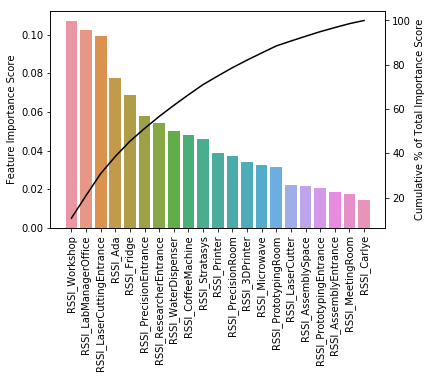

In [11]:
input_columns = train_data.loc[:,'RSSI_AssemblyEntrance':'RSSI_Printer'].columns.values.tolist()
plot_feature_importance(best_model, input_columns)

In [12]:
important_features = ['RSSI_Workshop','RSSI_LabManagerOffice','RSSI_LaserCuttingEntrance','RSSI_Ada','RSSI_Fridge',
                      'RSSI_PrecisionEntrance','RSSI_ResearcherEntrance','RSSI_WaterDispenser','RSSI_CoffeeMachine','RSSI_Stratasys',
                      'RSSI_Printer','RSSI_PrecisionRoom','RSSI_3DPrinter','RSSI_Microwave','RSSI_PrototypingRoom']
feature_index = [input_columns.index(feature) for feature in important_features]

# Retrain model based on most significant input features

In [13]:
retrained_model = hyperparameter_tuning(Xtrain[:,feature_index], Ytrain)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 47.4min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 70.5min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 116.8min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 173.3min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 216.2min finished


Best Model Parameters
{'n_estimators': 160, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5}


                                precision    recall  f1-score   support

                 AssemblySpace       1.00      0.53      0.69       398
              LaserCuttingRoom       0.93      0.89      0.91       938
                   MeetingRoom       0.66      0.94      0.78       195
                  OfficeArea_1       0.72      0.90      0.80       726
                  OfficeArea_2       0.92      0.83      0.87      1345
                           Out       1.00      1.00      1.00       154
    Pantry_FridgeCoffeeMachine       0.75      0.32      0.45       629
Pantry_MicrowaveWaterDispenser       0.12      0.56      0.20        55
                  Pantry_Other       0.21      0.43      0.28       123
                 PrecisionRoom       0.38      1.00      0.55        99
                       Printer       0.74      0.74      0.74       145
               PrototypingRoom       0.75      0.62      0.68       257

                      accuracy                           0.75 

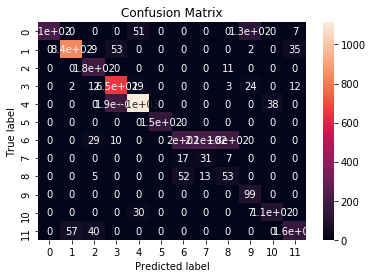

In [14]:
prediction = retrained_model.predict(Xtest[:,feature_index])
plot_model_performance(Ytest, prediction)